In [ ]:
import re
import html
import os
from collections import Counter, defaultdict
import math
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import random
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import requests
from scipy import stats

-----
## Part 1: Analyze the network

The questions answered in this part are based on Lecture 5.

- **Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.**
    - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
    - I would like you to include concepts like centrality and assortativity in your analysis.
    - Use a network backbone in your analysis.
    - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
    - Note: As I write above, an important part of the exercise consists is selecting the right elements of the lecture to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.
------

The network in question is a directed graph. 
The nodes are mainstream rock bands/performers (a list taken from wikipedia). The edges between nodes represent links between the wikipedia pages of the bands. Meaning, an edges from node 1 to node 2 represents a link in the wiki page of band 1 to the wiki page of band 2.
The network nodes (performers) has an atribute, "word_count", which represents the number of words in the wiki page of the performer.

A thourough walk through on how this network was made was given in Assignment 1. But it is important to note that the graph below we are working with throughout this exercse is the largest connected component in the original graph, meaning that we have removed nodes that have degree 0.

Below is the number of edges and nodes printed. To visualise the network, we have plotted the undirected version.

Number of nodes in G: 472
Number of edges in G: 7100


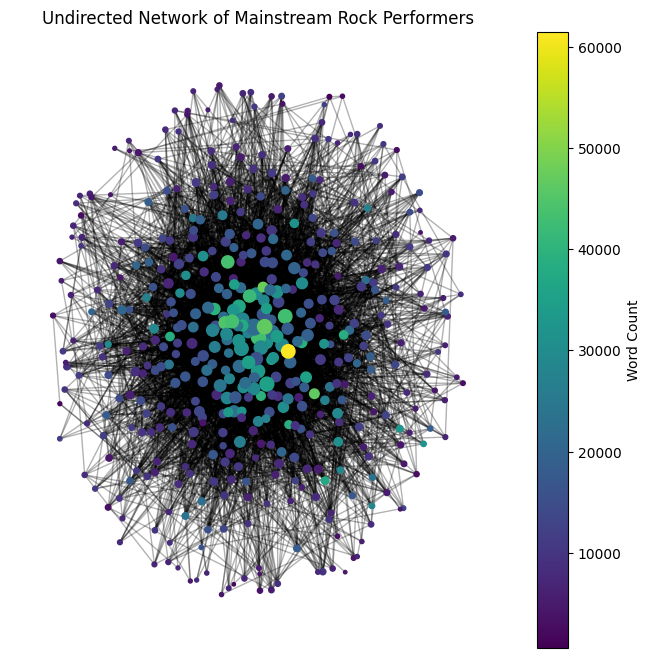

In [ ]:
#  Loading the graph from Github as decribed in the exercise

# TODO load rigtig graf fra git!!! TJEK at AllMusic ikke er med!!! (se degrees nedenfor))

# load graph from URL
#url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Noa/Bands_graph.graphml"# Loading graph from a GraphML file from a URL
#data = requests.get(url).text  
#G = nx.parse_graphml(data)

# load graph from local file
G = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Noa/Bands_graph.graphml")

#### BASIC INFO
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()}")

### VISULISATION
G_undirected = G.to_undirected()
# plot 
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G_undirected, seed=42, k = 0.8)  # positions for all 
#pos = nx.forceatlas2_layout(GCC_undirected, seed=42, strong_gravity=True)  # positions for all nodes

# node sizes based on degree
node_sizes = [5 + 1 * G_undirected.degree(n) for n in G_undirected.nodes()]

# node colors based on word count (content length)
node_colors = [G_undirected.nodes[n]['word_count'] for n in G_undirected.nodes()]
nodes = nx.draw_networkx_nodes(G_undirected, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)
plt.colorbar(nodes, label='Word Count')
plt.title('Undirected Network of Mainstream Rock Performers')
plt.axis('off')
plt.show()

Above, the network of mainstream rock performers is displayed. It has 473 nodes and 7452 edges. The size of the node represents the degree, ie. a big node has high degree and a small has low degree. The color of the node represents the word count of the wikipage of the performer, where yellow/green is a longer wiki page and purple/blue is a shorter wiki page. It is evident that the graph is highly connected and it is difficult to see anything specific because of the many edges making everything black. Inspite of this, it is possible to see that the yellow and green nodes are also the ones that are bigger and in the center of the network. Menaing that a band, that has a long wiki-text also has a lot of links (either/or coming from and/or going to).

To further investigate, we look at the in-degree and out-degrees of the nodes. Firstly, we will look at the mean, median, minimum, maximum, mode and distributions. 

In [105]:
# Degree statistics
out_degrees = [d for n, d in G.out_degree()]
in_degrees = [d for n, d in G.in_degree()]

# Out degree statistics
print("\nOut-Degree Statistics:")
print(f"Average Out-Degree: {np.mean(out_degrees)}")
print(f"Median Out-Degree: {np.median(out_degrees)}")
print(f"Minimum Out-Degree: {np.min(out_degrees)}")
print(f"Maximum Out-Degree: {np.max(out_degrees)}")
(unique, counts) = np.unique(out_degrees, return_counts=True)
frequencies = np.asarray((unique, counts)).T
mode_out_degree = frequencies[np.argmax(frequencies[:, 1]), 0]
print(f"Mode Out-Degree: {mode_out_degree}")

# In degree statistics
print("\nIn-Degree Statistics:")
print(f"Average In-Degree: {np.mean(in_degrees)}")
print(f"Median In-Degree: {np.median(in_degrees)}")
print(f"Minimum In-Degree: {np.min(in_degrees)}")
print(f"Maximum In-Degree: {np.max(in_degrees)}")
(unique, counts) = np.unique(in_degrees, return_counts=True)
frequencies = np.asarray((unique, counts)).T
mode_in_degree = frequencies[np.argmax(frequencies[:, 1]), 0]
print(f"Mode In-Degree: {mode_in_degree}")





Out-Degree Statistics:
Average Out-Degree: 15.042372881355933
Median Out-Degree: 13.0
Minimum Out-Degree: 1
Maximum Out-Degree: 69
Mode Out-Degree: 9

In-Degree Statistics:
Average In-Degree: 15.042372881355933
Median In-Degree: 10.0
Minimum In-Degree: 0
Maximum In-Degree: 117
Mode In-Degree: 4


Above we see that for both in and out degrees, the average is greater than the median (13 < 15 and 10 <15), indicating that the distributions are skewed to the left. This is also seen in the plots below. The mode shows, that the most common behavior is that a band page links to 9 other bands but most are only linked to by 4. The max in‑degree (117) is far from the median (10), this again indactes a skewed distribution (power‑law‑like). The out-degree has less of a difference, hereby indicating that it has a lighter tail. 
Below the distributions are plotted investigating further.

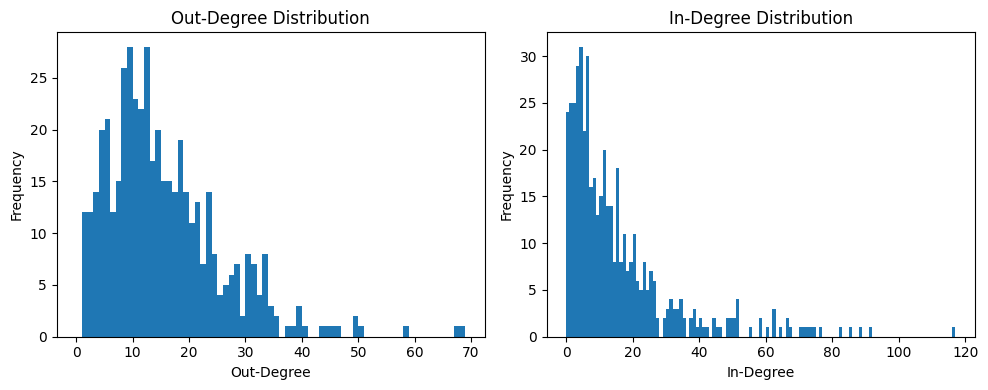

In [106]:

# plot histograms of out degrees and in degrees in 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(out_degrees, bins=range(max(out_degrees)+1))
axs[0].set_title('Out-Degree Distribution')
axs[0].set_xlabel('Out-Degree')
axs[0].set_ylabel('Frequency')

axs[1].hist(in_degrees, bins=range(max(in_degrees)+1))
axs[1].set_title('In-Degree Distribution')
axs[1].set_xlabel('In-Degree')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
    

The plots show out-degree (left) and in-degree (right) distributions of the network. The bins are size one on both graphs, the first bin (between 0 and 1 on the x-axis) represents the nodes having in/out degree 0 and so on for the following bins.  

We observe that there is a difference in the out and in degree distributions. The in degree distribution is heavily skewed (power-law like) to the left and the out degree is slightly skewed to the left. The peak is around 10 for the out-degree distribution. The peak of the in-degree distribution is around 5. Furthermore, no nodes have out-degree 0, but many have in-degree 0, meaning no bands does not link to others while many are not linked to. This behavior supports that there is a small group "elite" bands that a lot of the nodes point to, who has a high in-degree. It is worth to note here that we in the preparation of the network have removed all nodes that didn't connect to the largest component, which in this case was the nodes that had both in and out degree 0. From the right plot we see that a handfull of nodes has in-degree higher than 80, with around 20 nodes that has a higher degree than 60.

There are more nodes with low in-degree, than nodes with low out-degree. Which means that many link to more than one other band, while many are not linked to by other bands or only by few. 

This leads use to look at out-degree vs in-degree for the nodes. This we will do in a scatterplot below.


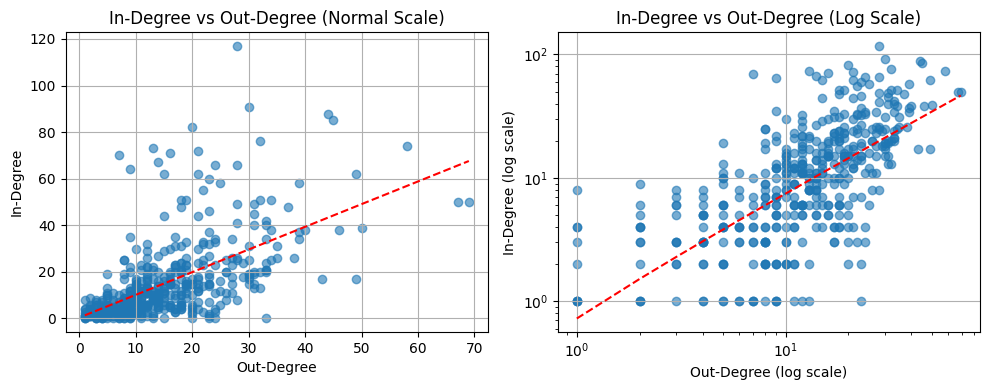

Node with high out-degree and zero in-degree: ['Mötley_Crüe']
Nodes with high in-degree and low out-degree: ['Pink_Floyd', 'Elvis_Presley']


In [107]:
# plot of in-degree vs out-degree scatterplot both in normal and log scale (subplots)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# non log
axs[0].scatter(out_degrees, in_degrees, alpha=0.6)
axs[0].set_xlabel('Out-Degree')
axs[0].set_ylabel('In-Degree')
axs[0].set_title('In-Degree vs Out-Degree (Normal Scale)')
axs[0].grid(True)
# make tendency line
z = np.polyfit(out_degrees, in_degrees, 1)
p = np.poly1d(z)
axs[0].plot(sorted(out_degrees), p(sorted(out_degrees)), "r--")

# log scale
axs[1].scatter(out_degrees, in_degrees, alpha=0.6)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Out-Degree (log scale)')
axs[1].set_ylabel('In-Degree (log scale)')
axs[1].set_title('In-Degree vs Out-Degree (Log Scale)')
axs[1].grid(True)
# make tendency line in log scale
log_out_degrees = np.log1p(out_degrees)
log_in_degrees = np.log1p(in_degrees)
z_log = np.polyfit(log_out_degrees, log_in_degrees, 1)
p_log = np.poly1d(z_log)
sorted_log_out_degrees = np.sort(log_out_degrees)
axs[1].plot(np.expm1(sorted_log_out_degrees), np.expm1(p_log(sorted_log_out_degrees)), "r--")
plt.tight_layout()
plt.show()

# There is one node with high outdegree (above 30) but low indegree (= 0).
# Find this node:
special_node_low_in = [n for n in G.nodes() if G.out_degree(n) > 30 and G.in_degree(n) == 0]

# There is two nodes with in degree above 60 and out degree below 10.
special_nodes_low_out = [n for n in G.nodes() if G.in_degree(n) > 60 and G.out_degree(n) < 10]


print(f"Node with high out-degree and zero in-degree: {special_node_low_in}")
print(f"Nodes with high in-degree and low out-degree: {special_nodes_low_out}")



The scatterplots above displays the indegree vs outdegree for all nodes in the network. The left displays on a normal scale and the right on a log scale (both x and y). A linear tendency is marked with red on both plots.

There’s a general upward trend in the plots. Nodes with larger out‑degree tend to also have higher in‑degree, but with large dispersion, especially as degree grows. The tendency line (red) is very close to y=x, nodes lying near it have similar in‑ and out‑degree. 

In the left plot (normal scale), the nodes are clustered in the bottom left corner, meaning that most nodes have low out or/and in degree. Only a few reach very high values (e.g. in‑degree around 100, out‑degree around 60).
The log–log plot reveals long tails (vertical and horizontal “bands” at degree 1 and small integers), a hallmark of scale‑free–like or at least skewed networks. This we also saw on the distributions.

It is clear on the plots, that there is a band that does link to many bands (above 30) but has no bands linking to them. This we have found to be Mötley Crüe. Furthermore there is two bands, that has many linking to them (above 60) but very few they link to (below 10), these are Pink Floyd and Elvis Presley. 

The first band (with low in-degree and high out-degree) is one we have never heard of, but we have google is a famous heavy metal band. The two bands with opposite degree properties are very known and defining performers. From this it seems like famous bands with extensive wiki pages both have high in- and/or out degree. Therefore we would like to calculate the correlation between the degrees and the word count, to get a better understanding of this. This is done below.


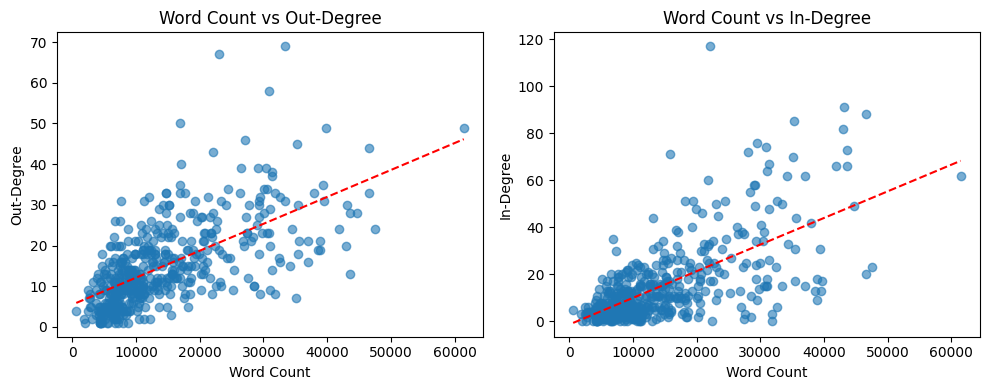

Pearson Correlation between Word Count and Out-Degree: 0.6293599413397419
Spearman Correlation between Word Count and Out-Degree: 0.6657751911850595 

Pearson Correlation between Word Count and In-Degree: 0.651842905149835
Spearman Correlation between Word Count and In-Degree: 0.6129146791513196


In [ ]:
# get word counts of all nodes in G
word_counts = [G.nodes[n]['word_count'] for n in G.nodes()]

# subplot word count vs out degree
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(word_counts, out_degrees, alpha=0.6)
axs[0].set_xlabel('Word Count')
axs[0].set_ylabel('Out-Degree')
axs[0].set_title('Word Count vs Out-Degree')
# tendency line
z = np.polyfit(word_counts, out_degrees, 1)
p = np.poly1d(z)
axs[0].plot(sorted(word_counts), p(sorted(word_counts)), "r--")

# subplot word count vs in degree
axs[1].scatter(word_counts, in_degrees, alpha=0.6)
axs[1].set_xlabel('Word Count')
axs[1].set_ylabel('In-Degree')
axs[1].set_title('Word Count vs In-Degree')
# tendency line
z = np.polyfit(word_counts, in_degrees, 1)
p = np.poly1d(z)
axs[1].plot(sorted(word_counts), p(sorted(word_counts)), "r--")
plt.tight_layout()
plt.show()

# pearson correlation (out-degree)
pearson_correlation_out = stats.pearsonr(word_counts, out_degrees)[0]
spearman_correlation_out = stats.spearmanr(word_counts, out_degrees)[0]
print(f"Pearson Correlation between Word Count and Out-Degree: {pearson_correlation_out}")
print(f"Spearman Correlation between Word Count and Out-Degree: {spearman_correlation_out} \n")

# pearson correlation (in-degree)
pearson_correlation_in = stats.pearsonr(word_counts, in_degrees)[0]
spearman_correlation_in = stats.spearmanr(word_counts, in_degrees)[0]
print(f"Pearson Correlation between Word Count and In-Degree: {pearson_correlation_in}")
print(f"Spearman Correlation between Word Count and In-Degree: {spearman_correlation_in}")


The plots above show the word-count vs the out-degree (left) and in-degree (right). A tendency line is shown as a red line on both plots. 

We observed that theres is a strong association between the wiki page length (word count) and both Out‑Degree and In‑Degree. Which the stated strong correlations also support. Neither of the degrees are particular more correlated with word-count than the other. This was also what we observed in the initial plot of the network above, where the wordcount was indicated on a color scale and the degree was indicated in the size of the node.

The correlation with out-degree, makes sense as longer articles usually have richer history/association sections and discographies, producing more links to other wiki pages and hereby also other  performers. Motley crue, is an example of this, a famous band with a long wikipage with details and many links.  
The correlation with in-degree, makes sense as very influential artists attract more references from peer pages. They also tend to have richer coverage and hereby longer pages. Word count seems a proxy for prominence/coverage, which also draws more incoming links and provides more opportunities to link out.

Now lets look at which bands/performers are the most important in the network. This is done by looking at degree centrality and betweenness centrality.


In [109]:
# 10 most central characters according to degree centrality.
degree_centrality = nx.degree_centrality(G)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_central = sorted_centrality[:10]
print("Top 10 most central characters by degree centrality:")
for character, centrality in top_10_central:
    print(f"{character}: {centrality}")

# 10 most central characters according to betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_betweenness = sorted_betweenness[:10]
print("\n")
print("Top 10 most central characters by betweenness centrality:")
for character, centrality in top_10_betweenness:
    print(f"{character}: {centrality}")

Top 10 most central characters by degree centrality:
Led_Zeppelin: 0.3078556263269639
Black_Sabbath: 0.2802547770700637
Queen__band_: 0.2802547770700637
Metallica: 0.2760084925690021
Bob_Dylan: 0.25690021231422505
Alice_in_Chains: 0.2526539278131635
Deep_Purple: 0.2484076433121019
Guns_N'_Roses: 0.2356687898089172
Jimi_Hendrix: 0.22929936305732485
David_Bowie: 0.21656050955414013


Top 10 most central characters by betweenness centrality:
Deep_Purple: 0.04288744233729137
Queen__band_: 0.04129527787350089
Guns_N'_Roses: 0.03745295495016443
Alice_in_Chains: 0.03576269489924573
Jimi_Hendrix: 0.03389112672769049
Black_Sabbath: 0.033688189929592306
Led_Zeppelin: 0.031621525006454036
Bob_Dylan: 0.028798304032036582
Metallica: 0.02577000515013545
Alice_Cooper: 0.025446990378799963


Fristly, we look at the most important performers in terms of degree centrality. These are the nodes referenced by many and/or referencing to many others. It is eveident that classic rock giants dominate, which makes sense given their historical influence and frequent mentions. These artists have the most direct connections (sum of in-degree and out-degree normalized).
In contrast, the betweenness measures how often a node (performer) lies on the shortest paths between other nodes, i.e. how many times they have a “bridge” role.

Deep Purple and Queen are not only well-connected (high deg. centrality) but they also act as connectors between subgroups, this could be subgroups in terms of genres or eras.

Led Zeppelin and Black Sabbath rank highest in degree but lower in betweenness, this suggests they are the biggest hubs but not necessarily as important bridges. We see that Alice in Chains and Guns N' Roses are on the betweenness list, which suggests some bridging between classic rock and later subgenres (grunge, hard rock).

Classic rock and early metal dominate both lists, showing their central role in mainstream rock (reflected by the structure of the links of their wikipages). 

Looking at the wikipages of the bands on the btweenness list, most of them have exprimented with different subgenres of rock music or have collaborated with bands in different styles.  

The normalized values (0.30 for degree, 0.04 for betweenness) suggest moderate centralization. There is no single node dominating completely.

It would be interesting to look at these dominating nodes, with high degree centrality, if they are linking to each other. Therefore, we will look at the assortativity in the network. 

In [ ]:
# Assortativity coefficient of the undirected graph with respect to degree
assortativity_coefficient = nx.degree_assortativity_coefficient(G.to_undirected())
print(f"\nAssortativity coefficient of the undirected graph with respect to degree: {assortativity_coefficient}")
# Assortativity coefficient of the directed graph with respect to word_count
word_count_assortativity = nx.attribute_assortativity_coefficient(G.to_undirected(), 'word_count')
print(f"Assortativity coefficient of the directed graph with respect to word_count: {word_count_assortativity} \n")

# Assortativity coefficient of the highest degree nodes
highest_degree_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
subgraph = G.subgraph([n for n, d in highest_degree_nodes])
highest_degree_assortativity = nx.degree_assortativity_coefficient(subgraph.to_undirected())
print(f"Assortativity coefficient of the highest degree nodes: {highest_degree_assortativity}") 
# Assortativity coefficient of the lowest degree nodes
lowest_degree_nodes = sorted(G.degree(), key=lambda x: x[1])[:100]
subgraph_low = G.subgraph([n for n, d in lowest_degree_nodes])
lowest_degree_assortativity = nx.degree_assortativity_coefficient(subgraph_low.to_undirected())
print(f"Assortativity coefficient of the lowest degree nodes: {lowest_degree_assortativity}")
# Assortivity of middle degree nodes with degree between 25th and 75th percentile
middle_degree_nodes = sorted(G.degree(), key=lambda x: x[1])[len(G)//4:3*len(G)//4]
subgraph_mid = G.subgraph([n for n, d in middle_degree_nodes])
middle_degree_assortativity = nx.degree_assortativity_coefficient(subgraph_mid.to_undirected())
print(f"Assortativity coefficient of the middle degree nodes: {middle_degree_assortativity} \n")

# Assortativity coefficient of the nodes with highest word count
highest_word_count_nodes = sorted(G.nodes(data=True), key=lambda x: x[1]['word_count'], reverse=True)[:10]
subgraph_wc = G.subgraph([n for n, d in highest_word_count_nodes])
highest_word_count_assortativity = nx.attribute_assortativity_coefficient(subgraph_wc.to_undirected(), 'word_count')
print(f"Assortativity coefficient of the nodes with highest word count: {highest_word_count_assortativity}")
# Assortativity coefficient of the nodes with lowest word count
lowest_word_count_nodes = sorted(G.nodes(data=True), key=lambda x: x[1]['word_count'])[:100]
subgraph_wc_low = G.subgraph([n for n, d in lowest_word_count_nodes])
lowest_word_count_assortativity = nx.attribute_assortativity_coefficient(subgraph_wc_low.to_undirected(), 'word_count')
print(f"Assortativity coefficient of the nodes with lowest word count: {lowest_word_count_assortativity}")
# Assortivity of middle word count nodes with word count between 25th and 75th percentile
middle_word_count_nodes = sorted(G.nodes(data=True), key=lambda x: x[1]['word_count'])[len(G)//4:3*len(G)//4]
subgraph_wc_mid = G.subgraph([n for n, d in middle_word_count_nodes])
middle_word_count_assortativity = nx.attribute_assortativity_coefficient(subgraph_wc_mid.to_undirected(), 'word_count')
print(f"Assortativity coefficient of the middle word count nodes: {middle_word_count_assortativity}")


Assortativity coefficient of the undirected graph with respect to degree: 0.0045703090953323686
Assortativity coefficient of the directed graph with respect to word_count: -0.00346922370720667 

Assortativity coefficient of the highest degree nodes: -0.1328577797592491
Assortativity coefficient of the lowest degree nodes: -0.19828815977175424
Assortativity coefficient of the middle degree nodes: 0.08123404639607505 

Assortativity coefficient of the nodes with highest word count: -0.11920529801324503
Assortativity coefficient of the nodes with lowest word count: -0.020315617631053877
Assortativity coefficient of the middle word count nodes: -0.005993974860625368


The calculations above are done on the undirected version of the network.

The assortiative coefficient of the whole network is calculated above (first section) with respect to degree and word count. We oberseve that the network is neutral with respect to both degree and word count, as the values are very close to zero. This means that links are roughly random with respect to degree/word count similarity. 

Furthermore, we have looked at the subgraphs to see the behavoir between nodes of similar degree and word count (section 2 and 3 above respectively).

Firstly looking at assortivity with respect to degree. In the subgraph, containing only the nodes with the 10 highest degrees, the coefficient is -0.13, i.e. the subgraph is disassortative. This means that the biggest hubs do not mostly link to other hubs, i.e. they mostly connect downward to lower‑degree nodes. There is no tight “club” between the highest degree nodes (hub-and-spoke). Looking at the 100 lowest degree nodes, the subgraph has coefficient -0.19, i.e. this subgraph is also disassortative. Low‑degree bands tend to attach upward to higher‑degree bands rather than to each other. Lastly, in the subgraph of the nodes with degree in the 25th and 75th percentile, the coefficient is 0.08, slightly possitive. Hereby they have a slight tendency to link to nodes of same degree. 
Put together, this explains why the overall coefficient is almost 0. The top and the bottom are both mildly disassortative and their effects largely cancel once you include the middle of the distribution, wich is slightly assortative.

Secondly looking at assortativity with respect to the word count, all three subgraphs (10 highest, 100 lowest, 25th-75th precentile) have negative or close to 0 coefficient. The top-10 (the moste extensive wikipages of bands) is disassortative while the others are neutral, meaning the high word count pages have a tendency to connect to nodes of lower and mid word count pages don’t show strong linking preferences among themselves. This hereby, explains the overall coefficient is almost 0, Only the very top has linking preference while the majority of the network does not.


Finally, we want to make a better visualization of the graph, by plotting the network backbone (removing less important nodes and edges). This way we have a better understanding of the structure. 

Number of nodes in backbone: 248
Number of edges in backbone: 209


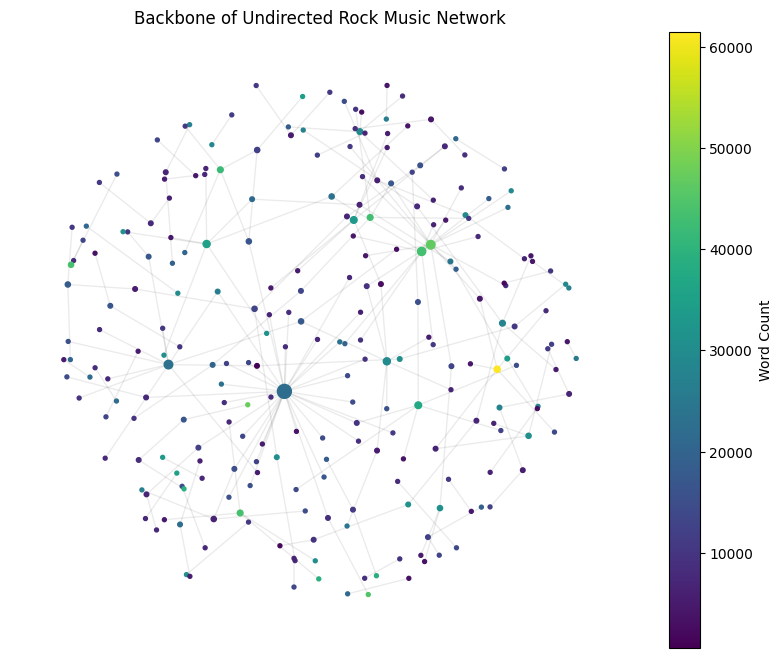

Top 5 edges with highest weights in the backbone:
Edge (Elvis_Presley, Shakin'_Stevens) with weight: 100.0
Edge (Billy_Idol, Tommy_James_and_the_Shondells) with weight: 100.0
Edge (Roxy_Music, The_Fixx) with weight: 100.0
Edge (Guns_N'_Roses, The_Presidents_of_the_United_States_of_America__band_) with weight: 99.99999999999997
Edge (Bob_Dylan, Michael_Martin_Murphey) with weight: 88.23424026288316

Top 5 hubs in the backbone (nodes with highest degree):
Node Led_Zeppelin with degree: 32
Node Queen__band_ with degree: 11
Node Deep_Purple with degree: 11
Node Bob_Dylan with degree: 10
Node Jimi_Hendrix with degree: 7


In [ ]:
# Creating Weighted Network 1, where edge weights are proportional to edge betweenness centrality
G_undirected_1 = G.to_undirected()
# compute edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(G_undirected_1)
# normalize edge betweenness to [1, 100]
min_eb = min(edge_betweenness.values())
max_eb = max(edge_betweenness.values())
def renormalize(value, min_val, max_val):
    return 1 + (value - min_val) * (100 - 1) / (max_val - min_val)
for u, v in G_undirected_1.edges():
    G_undirected_1[u][v]['weight'] = renormalize(edge_betweenness.get((u, v), 0), min_eb, max_eb)


# Disparity Filter method, using edge weights.
def disparity_filter(G, alpha=0.05):
    backbone = nx.Graph()
    for node in G.nodes():
        k = G.degree(node)
        if k > 1:
            sum_w = sum([G[node][nbr]['weight'] for nbr in G.neighbors(node)])
            for nbr in G.neighbors(node):
                p_ij = G[node][nbr]['weight'] / sum_w
                alpha_ij = (1 - p_ij) ** (k - 1) 
                if alpha_ij < alpha: 
                    backbone.add_edge(node, nbr, weight=G[node][nbr]['weight'])
                    backbone.nodes[node]['word_count'] = G.nodes[node]['word_count'] # for plotting later
                    backbone.nodes[nbr]['word_count'] = G.nodes[nbr]['word_count'] # for plotting later
    return backbone


backbone1 = disparity_filter(G_undirected_1, alpha=0.07)
print(f"Number of nodes in backbone: {backbone1.number_of_nodes()}")
print(f"Number of edges in backbone: {backbone1.number_of_edges()}")
# Visualize the backbone
plt.figure(figsize=(10,8))
pos = nx.spring_layout(backbone1, seed=42, k = 0.8)
# node sizes based on degree
node_sizes = [5 + 3 * backbone1.degree(n) for n in backbone1.nodes()]
# node colors based on word count (content length)
node_colors = [backbone1.nodes[n]['word_count'] for n in backbone1.nodes()]
nodes = nx.draw_networkx_nodes(backbone1, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(backbone1, pos, alpha=0.08)
plt.colorbar(nodes, label='Word Count')
plt.title('Backbone of Undirected Rock Music Network')
plt.axis('off')
plt.show()


# Find the top 5 edges with highest weights in the backbone
top_5_edges = sorted(backbone1.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
print("Top 5 edges with highest weights in the backbone:")
for u, v, data in top_5_edges:
    print(f"Edge ({u}, {v}) with weight: {data['weight']}") 

# Find the big hubs in the backbone (nodes with highest degree)
top_5_hubs = sorted(backbone1.degree(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 hubs in the backbone (nodes with highest degree):")
for node, degree in top_5_hubs:
    print(f"Node {node} with degree: {degree}")




The above figure is the backbone of the undirected mainstream rock music network (248 nodes and 209 edges), extracted using the Disparity filter with edge weights proportional to edge betweenness centrality (normalized to be between 1 and 100). The backbone only consist of edges that are significant for at least one endpoint. This graph emphasizes ties that carry shortest‑path flow. The node sizes reflects the degree of the node. Node color reflects the word count (yellow = longer pages, purple = shorter). 

Because the edge weights are proportional to edge betweenness, the disparity filter preferentially keeps inter‑community links. These are the links that carry a disproportionate share of shortest‑path flow for at least one of the endpoints. We see that there are a few bridging hubs (top 5 five are listed above) in the structure which aligns with the assortativity analysis above (mildly disassortative among the biggest nodes). Especially one hub, Led Zepplin, has a high degree in the backbone acting as a main connector.

Furthermore, we have printed the edges with the highest betweeness centrality (normalized), see the list above. Here we see that the links (Elvis - Shakin' Stevens), (Billy Idol - Tommy James and the Shondells), (Roxy Music - The Fixx) and (Guns N' Roses - The Presidents of the United States of America) are links critical for shortest-path connectivity. They likely represent genre and/or linkings that otherwise are quite seperate communities. 


#TODO skriv en konklusion på hele denne opgave, hvad vi kan sige om bands osv fra det vi har analyseret. Hvad er tendensen i band strukturer osv.

----

# Part 2: Genres and communities and plotting
The questions below are based on Lecture 7, part 2.
- Write about genres and modularity
- Detect the communities, discuss the value of modularity in comparison to the genres.
- Plot the communities and comment on your results.
- Calculate the matrix $D$ and discuss your findings.
------

## Write about genres and modularity

Modularity is a measure that evaluates how well a network partitioning devides the network into communities. It does this by comparing the density of edges inside the communities vs the density between the communites. 
A high moduality means that the nodes of the communities are highly connected and there are few connections between the communities. A modularity of 1 means that there are only edges inside communities and no edges between communities, i.e. communities are perfectly seperated. A low modularity, around 0, means that there is no more community structure than there would be in a random network. Modularity can also be negative, and this means that the community structure is weaker than if the network had been random.

When we group/partition nodes based on genre, the modularity measure tells us something about if the bands that play the same genre music often will link to each other, or do they often link across genres. A high modularity would suggest that for instance pop-rock bands link primarily to other pop-rock bands.

## Detect the communities, discuss the value of modularity in comparison to the genres

As in part 1, we are using the network of mainstream rock performers.

To detect communities we firstly create a network of all the bands where an attribute on each node is all the genres listed in their wiki-infobox. To be able to compare and group the bands later we will add the genres in lowercase and normalize the genre names, e.g. "R&B"->"rhythm and blues" etc. We have also chosen to remove the qualifiers of genres stating if the genre is "(early)" or "(later)" to make fewer categories and see stronger patterns.

In the following code we have created the functions to detect the genres inside the infoboxes of the plain wiki-text of the bands, and a function to clean the found genres. This is made using an LLM, as we did in the exercises from week 7.

In [ ]:
def extract_genres_from_wikitext(wikitext_content):
    """
    Extract a cleaned, normalized list of genres from Wikipedia-like wikitext.
    - Removes refs, citation templates, wrapper templates, HTML, and wiki links.
    - Strips all parenthetical qualifiers (e.g., '(early)', '(late)') and broken tails.
    - Lowercases all genres.
    - Normalizes common variants (rock & roll, r&b, hip-hop, post punk, synth pop, etc.).
    - Drops obvious template/config noise.
    - Deduplicates while preserving order.
    """
    # Isolate the 'genre =' field in the infobox
    m = re.search(
        r'\|\s*genre\s*=\s*(.*?)(?=\n\s*\||\n}})',
        wikitext_content,
        flags=re.DOTALL | re.IGNORECASE
    )
    if not m:
        return []
    g = m.group(1)

    # Decode HTML entities (&lt;ref&gt; -> <ref>, &amp; -> &, etc.)
    g = html.unescape(g)

    # Remove HTML comments
    g = re.sub(r'<!--.*?-->', '', g, flags=re.DOTALL)

    # Remove references: self-closing BEFORE paired to avoid cross-line capture
    g = re.sub(r'<ref[^>]*/>', '', g, flags=re.DOTALL | re.IGNORECASE)                      # <ref .../>
    g = re.sub(r'<ref(?:(?!/>)[^>])*?>.*?</ref>', '', g, flags=re.DOTALL | re.IGNORECASE)   # <ref ...>...</ref>

    # Remove citation/footnote templates entirely
    g = re.sub(r'\{\{\s*cite[^{}]*\}\}', '', g, flags=re.IGNORECASE)                        # {{cite web|...}}
    g = re.sub(r'\{\{\s*harv-?nb?[^{}]*\}\}', '', g, flags=re.IGNORECASE)                   # {{harvnb}}, {{harv-nb}}
    g = re.sub(r'\{\{\s*(sfn|sfnb|efn|refn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)         # {{sfn}}, {{refn}}, etc.
    g = re.sub(r'\{\{\s*(citation needed|cn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)        # {{citation needed}}, {{cn}}

    # Drop wrapper templates but keep their inner content
    g = re.sub(r'\{\{\s*(flatlist|hlist|nowrap|plainlist|ubl|unbulleted list)\s*\|?', '',
               g, flags=re.IGNORECASE)

    # Remove remaining braces and HTML tags like <small>, <i>, etc.
    g = g.replace('{{', '').replace('}}', '')
    g = re.sub(r'<[^>]+>', '', g)

    # Replace wiki links [[A|B]] -> B; [[A]] -> A
    g = re.sub(r'\[\[(?:[^|\]]+\|)?([^\]]+)\]\]', r'\1', g)

    # Normalize whitespace (incl. NBSP) and bullets
    g = g.replace('\xa0', ' ')
    g = g.replace('*', ' ')

    # Split on common delimiters
    parts = re.split(r'[\n,;•·]+|\s*\|\s*', g)

    # --- Normalization helpers ---

    # Canonical mapping for near-duplicates and synonyms (all keys/values lowercase)
    CANON_MAP = {
        # rock and roll family
        "rock & roll": "rock and roll",
        "rock and roll": "rock and roll",
        "rock 'n' roll": "rock and roll",
        "rock ’n’ roll": "rock and roll",
        "rock `n` roll": "rock and roll",

        # r&b / rhythm & blues
        "r&b": "rhythm and blues",
        "r & b": "rhythm and blues",
        "rhythm & blues": "rhythm and blues",

        # hip hop
        "hip-hop": "hip hop",
        "hip–hop": "hip hop",

        # hyphen/space variants
        "post punk": "post-punk",
        "synth pop": "synth-pop",
        "dance rock": "dance-rock",
        "blue eyed soul": "blue-eyed soul",

        # AOR
        "aor": "album-oriented rock",
    }

    # Regexes for pattern families
    ROCKNROLL_RX = re.compile(r"rock\s*(?:&|and|['`´’]\s*n['`´’])\s*roll")
    HIPHOP_RX    = re.compile(r"hip\s*[-–]?\s*hop")
    RAND_B_RX    = re.compile(r"(?:^|\b)r\s*&\s*b(?:\b|$)|rhythm\s*&\s*blues")

    # Token acceptability: letters (incl. accents), numbers, space, hyphen, apostrophes/quotes, ampersand, dots
    ALLOWED_RX   = re.compile(r"^[0-9A-Za-zÀ-ÖØ-öø-ÿ\s\-\&'`´’\.]+$")

    # Substrings indicating template/config noise to drop
    DROP_SUBSTRS = [
        'citation', 'cite', 'access-date', 'archive-url', 'archive-date',
        'publisher=', 'website=', 'title=', 'url=', 'first=', 'last=',
        'class=', 'nowrap', 'italic', 'lang', 'script=', 'format='
    ]

    def normalize_label(t: str) -> str:
        # Trim punctuation
        t = t.strip()
        t = re.sub(r'^[\W_]+|[\W_]+$', '', t)
        if not t:
            return ''

        # Drop obvious noise
        lo = t.lower()
        if any(s in lo for s in DROP_SUBSTRS):
            return ''

        # Remove any parenthetical parts, even if multiple (e.g., "(early)", "(later)")
        t = re.sub(r'\s*\([^)]*\)', '', t).strip()
        # If an unmatched '(' tail remains, drop that too (e.g., "funk metal (early")
        t = re.sub(r'\s*\([^)]*$', '', t).strip()

        # Lowercase
        t = t.lower()

        # Normalize rock and roll forms
        if ROCKNROLL_RX.search(t):
            t = ROCKNROLL_RX.sub('rock and roll', t)

        # Normalize hip hop forms
        if HIPHOP_RX.search(t):
            t = HIPHOP_RX.sub('hip hop', t)

        # Normalize r&b / rhythm & blues
        if RAND_B_RX.search(t):
            t = 'rhythm and blues'

        # Apply canonical map (covers aor, synth-pop, post-punk, blue-eyed soul, dance-rock, etc.)
        t = CANON_MAP.get(t, t)

        # Reject invalid tokens (after normalization)
        if not ALLOWED_RX.match(t):
            return ''

        # Collapse repeated spaces and strip stray punctuation
        t = re.sub(r'\s{2,}', ' ', t).strip('. ').strip()

        return t

    cleaned = [normalize_label(p) for p in parts]
    cleaned = [c for c in cleaned if c]

    # Deduplicate while preserving order (already lowercase)
    out, seen = [], set()
    for x in cleaned:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

In the following we loop through all wiki-texts of bands in a directory and make a dictionary of the bands and their genres.

In [ ]:
# Directory where all band data files are located
data_directory = "../Noa/Bands" #TODO
band_genres = {}

# Iterate over all files in the specified directory
for filename in os.listdir(data_directory):
    file_path = os.path.join(data_directory, filename)
    band_name = os.path.splitext(filename)[0] # Get band name from filename

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

            wikitext_content = content

            genres = extract_genres_from_wikitext(wikitext_content)
            band_genres[band_name] = genres
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# order the band list alphabetically
band_genres = dict(sorted(band_genres.items()))

The top 15 genres are listed below in a histogram

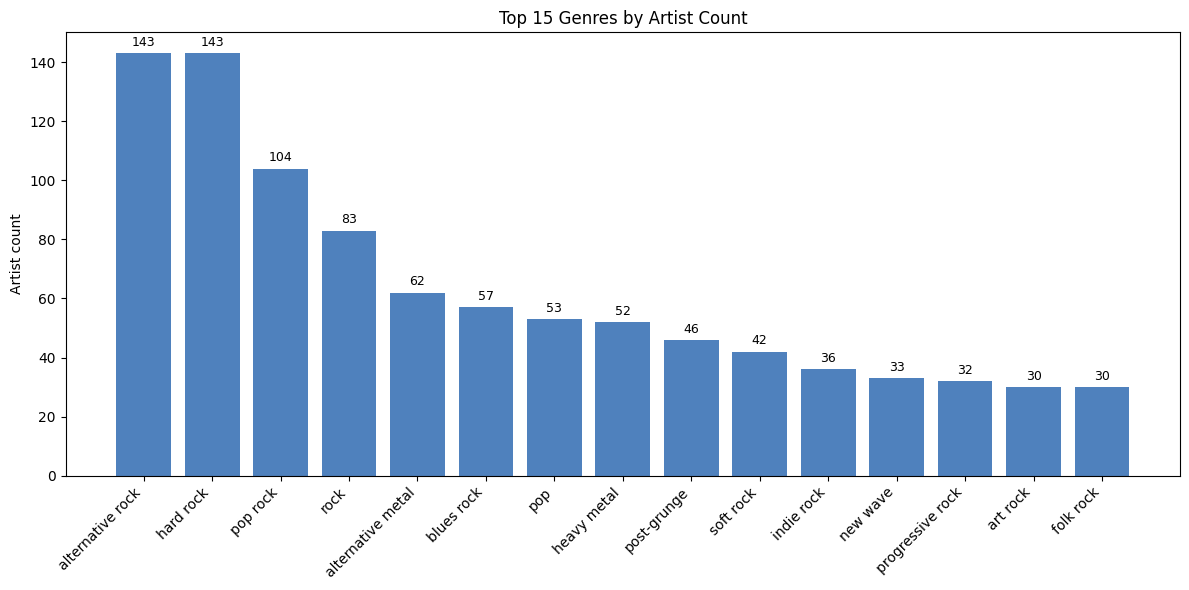

In [ ]:
# Artists with at least one genre
artists_with_genres = {artist: genres for artist, genres in band_genres.items() if genres}

# Top-15 genres histogram (by artist counts)

# Count per genre (ensures an artist counted only once per genre even if duplicates slipped in)
genre_to_artists = defaultdict(set)
for artist, genres in artists_with_genres.items():
    for g in set(genres):  # set() to be safe against accidental duplicates
        genre_to_artists[g].add(artist)

genre_counts = Counter({g: len(artist_set) for g, artist_set in genre_to_artists.items()})

top_n = 15
top15 = genre_counts.most_common(top_n)

# Plot
if top15:
    genres_plot, counts_plot = zip(*top15)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(genres_plot)), counts_plot, color="#4F81BD")
    plt.xticks(range(len(genres_plot)), genres_plot, rotation=45, ha='right')
    plt.ylabel("Artist count")
    plt.title(f"Top {top_n} Genres by Artist Count")
    # Add value labels on bars
    for bar, val in zip(bars, counts_plot):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts_plot)*0.01,
                 str(val), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No genres to plot for histogram (top15 is empty).")

Above we have on the y-axis the frequency/the number of bands that have the genre on the x-axis as one of their listed genres in their wiki-infobox. It is worth to note that a lot of these genres are rock sub-genres, but we have chosen not to join these genres into one and keep them seperated. 

We see that the band/performer pool is dominated by the alternative rock and hard rock genre. Pop rock and rock are also heavily represented. Metal is also represented in the histogram with subgenres alternative and heavy, having 62 and 52 counts respectively. 


We would now like to explore how community-like the communities are, if we consider the genres to be community labels. We use the modularity measure to do this. We firstly create the undirected links between the bands and we only keep the bands that actually have infoboxes and have a genre list in their wiki-text. The links between bands are added using the graph constructed for Assignment 1 (the one also used in part 1).

Removed 15 nodes with no links. The graph now has 457 nodes and 5569 edges.


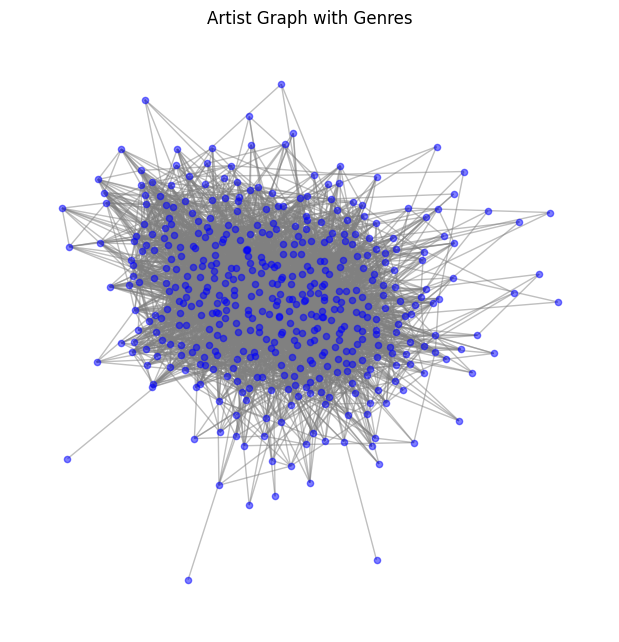

In [ ]:
# Create an empty graph
G_artists = nx.Graph()

# Add nodes to the graph from the artists_with_genres
# The keys of the dictionary are the artist names (nodes)
# The values are the lists of genres (attributes)
for artist, genres in artists_with_genres.items():
    G_artists.add_node(artist, genres=genres)

# Load the original links graph from Assignment 1
#G_links = nx.read_graphml(r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Noa/Bands_graph.graphml")
G_links = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Noa/Bands_graph.graphml")
# Adding edges to G_artists based on G_links
G = G_artists.copy()

for u, v in G_links.edges():
    if G.has_node(u) and G.has_node(v):
        G.add_edge(u, v)

# NOTE: G is now our final graph with genres as node attributes and the links are the original links from Assignment 1 and all nodes are removed that has no info-box

# Remove nodes with no links
nodes_to_remove = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_to_remove)
print(f"Removed {len(nodes_to_remove)} nodes with no links. The graph now has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.5)
plt.title("Artist Graph with Genres")
plt.show()


Above we have chosen to remove the bands/nodes that doesn't have any links, as these could contribute to the modularity measure being misleading. This is because isolated nodes have no edges, so they do not contribute to community structure. These nodes will likely be assigned to their own “community” by most algorithms. When we later try to create louvain communities this will most likely create many tiny communities, lowering modularity and making the network look fragmented.

To create the partitioning we choose the first genre in the list as the label for the node/band. This makes each community be the group of nodes that share the same first genre in their list of genres. We then calculate the modularity according to Eq. 9.12 in the book.

In [ ]:
# Each node is assigned to the community of its first listed genre
communities_by_genre = defaultdict(list)
for node, data in G.nodes(data=True):
    genres = data.get('genres')
    if genres:
        first_genre = genres[0]
        communities_by_genre[first_genre].append(node)

# a list of sets (the communities).
partition = [set(nodes) for nodes in communities_by_genre.values()]

def modularity(G, partition):
    """
    Compute modularity using Eq. 9.12:
    """
    L = G.number_of_edges()  # total edges
    degrees = dict(G.degree())

    M = 0.0
    for community in partition:
        # Internal edges in community
        L_c = G.subgraph(community).number_of_edges()
        # Sum of degrees in community
        k_c = sum(degrees[node] for node in community)
        M += (L_c / L) - (k_c / (2 * L)) ** 2

    return M

# Calculate and report the modularity 
mod = modularity(G, partition)
print(f"\nCreated a partition with {len(partition)} communities based on the first genre.")
print(f"Modularity: {mod:.4f}")


Created a partition with 77 communities based on the first genre.
Modularity: 0.0944


From the modularity we can conclude that the genres are not good communities. 
A score near or below zero indicates the partitioning is no better than random. In our case (with a modularity of 0.0944) this means that there is no community based on the first genre in the list compared to how the bands link to each other on their wiki-pages. It indicates that there is substantial cross-genre linking in the network, reducing the density difference between intra-genre and inter-genre edges. This may be cause by the fact that many of the bands/performers have multiple genres and the "first genre" communities oversimplifies the reality. 

We also assume that a lot of links are based on collaborations, influnce and historical context, which probably does not nessecarily make the links stay inside the comunnities. 

We have chosen to make anpother partisioning, to compare with. 
Instead of choosing the first genre as the base for the partitioning, we instead choose a random genre. It might improve/worsen the community structure.

In [ ]:
random.seed(42)

communities_by_genre_rand = defaultdict(set)

for node, data in G.nodes(data=True):
    genres = data.get('genres') or []
    if not genres:
        continue
    chosen = random.choice(genres)  # uniform random choice among available genres
    communities_by_genre_rand[chosen].add(node)

# Remove empty sets and return as list of sets
partition_rand = [nodes for nodes in communities_by_genre_rand.values() if nodes]

M_rand = modularity(G, partition_rand)
print(f"Random-genre partition modularity: {M_rand:.4f}")

Random-genre partition modularity: 0.0365


For this partitioning, the modularity is 0.0365. Again, the random choosing of genre for each band also produces very low modularity in the network. This was expected. 

Looking at both measures, the "first genre" partitioning is almost a factor 3 higher than the "random genre". Even though they both have low modularity, this does suggest that the first genre in the infoboxes is not arbitrary, it does capture some structure. Though it is important to say, that this structure is weak.

Hereby, we can conclude that the first listed genre is a weak predictor of network connectivity. This could potentially be because many bands does not only have one genre but many. Furthermore, picking a random genre fro the bends list only dilutes structure further. This indicates that the primary genere of bands/performers is usually listed first. 

Note that we have only done one random picking, which means we do not know how much the partitioning modularity can/will vary between random picks and what the mean value is. We have only looked at a single instance. 

## Plot the communities and comment on your results

We will now use the Louvain-algorithm to find communities for the network.

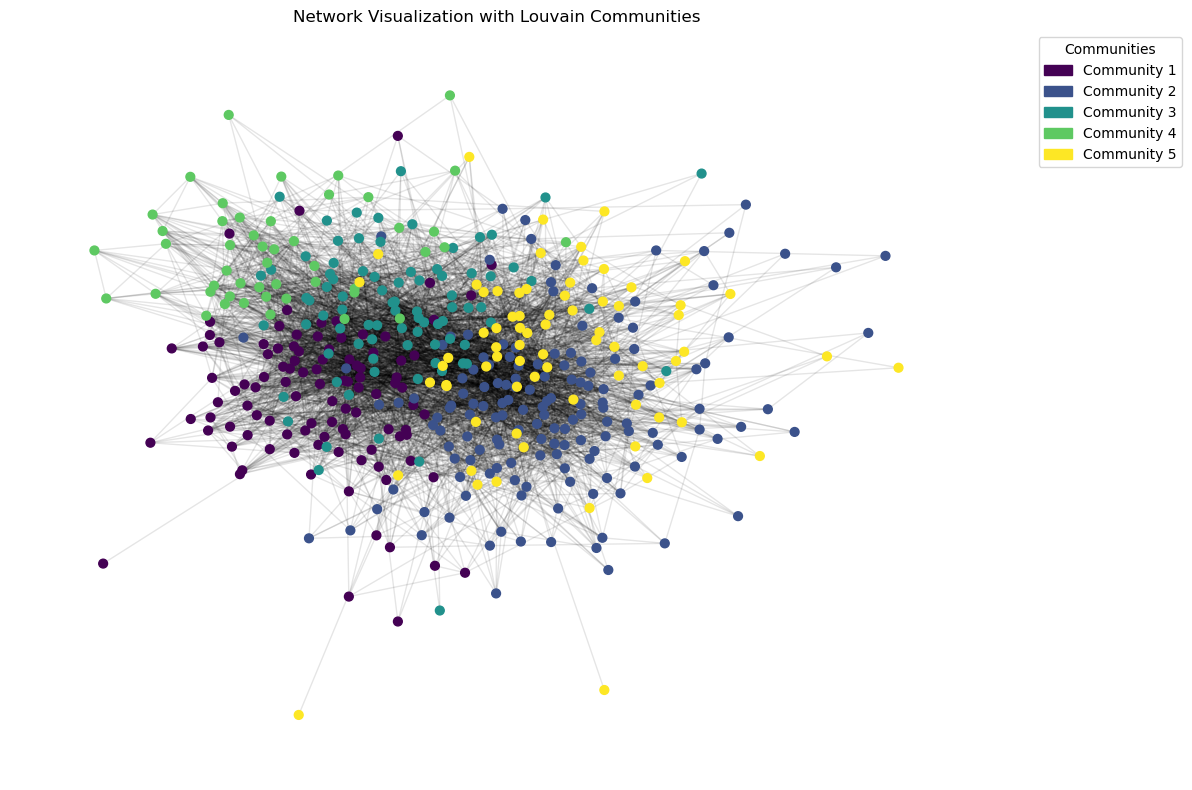


Louvain method found 5 communities with a modularity of 0.3390.


In [ ]:
# using networkx louvain_communities to find communities
louvain_communities = list(nx.community.louvain_communities(G, seed=11))
louvain_modularity = nx.community.modularity(G, louvain_communities)

# visualize the network using the Force Atlas algorithm with communities colored differently
# using louvain_communities
partition = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        partition[node] = i


# Set the size of the plot
plt.figure(figsize=(12, 8))
# Compute the layout using spring layout (Force Atlas-like)
pos = nx.spring_layout(G, seed=42)
# Draw nodes with colors based on their community
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)
# We will create custom legend handles because networkx doesn't do it automatically
legend_handles = []
for i in range(len(louvain_communities)):
    legend_handles.append(Patch(color=cmap(i), label=f'Community {i+1}'))

plt.legend(handles=legend_handles, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Network Visualization with Louvain Communities")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nLouvain method found {len(louvain_communities)} communities with a modularity of {louvain_modularity:.4f}.")

Above is a network visualization of the mainstream rock performers with communities detected using the Louvain algorithm.
Nodes are colored by their assigned community and edges represent the links between the wikipages of the bands/performers. 

The Louvain partitioning identifies five major communities. We observe that the nodes (bands) are largely grouped by color, indicating that the Louvain communities are visually distinct in the network. For example, the purple community (Community 1) is concentrated in the southwest region of the graph, while the green community (Community 4) is in the northwest region.
This partitioning has modularity 0.339, which indicates strong community structure. The Louvain method group nodes based on actual link patterns, not the strict first genre labels. This produced far more cohesive clusters, also capturing collaborations, influence and historical context of the bands.

When we rerun the Louvain algorithm with a different random seed, the number of detected communities can change, as the Louvain algorithm is a heuristic algorithm. For instance, if the method produces only 4 communities instead of more, this could be because the yellow and dark blue communities (Communities 5 and 2) are merged. This makes sense visually, as these two clusters overlap significantly. Similarly, the turquoise community (Community 3), which sits near the center of the network and overlaps with multiple other communities, might be split and redistributed across neighboring clusters in such cases.

The partitioning is now much more community-like now, as the moduality is higher 0.3390. This suggest a moderate community structure and that that there is a community structure in the partitioning compared to a random linking or the before seen genre based partitioning.

We will now create and visualize the confusion matrix comparing the Louvain communities with music genres

## Calculate the matrix $D$ and discuss your findings

We will now compare the communities found by the Louvain algorithm with the music genres by creating a matrix D with dimension (GxC), where G is the 5 most common genres and C is the 5 most common communities. We set entry D(i,j) to be the number of nodes that genre i has in common with community j.

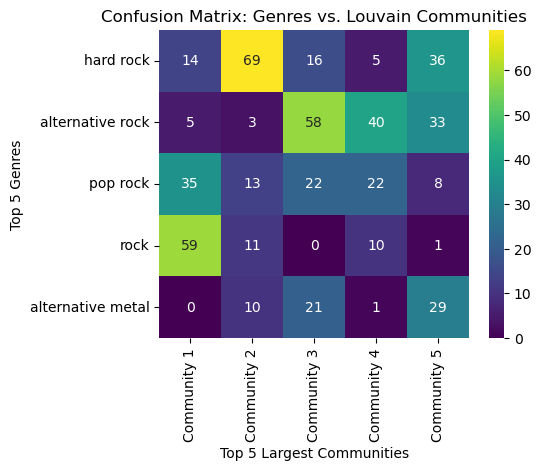

In [ ]:
# Identify the 5 most common genres - Using all genres associated with each node
all_genres_list = []
for node, data in G.nodes(data=True):
    if 'genres' in data:
        all_genres_list.extend(data['genres'])

genre_counts = Counter(all_genres_list)
top_5_genres = [genre for genre, count in genre_counts.most_common(5)]
top_5_genres_set = set(top_5_genres)


# Identify the 5 largest communities
louvain_communities.sort(key=len, reverse=True)
top_5_communities = louvain_communities[:5]

# Create a set of all nodes that are in one of the top 5 communities
nodes_in_top_communities = set()
for community in top_5_communities:
    nodes_in_top_communities.update(community)


genre_to_idx = {genre: i for i, genre in enumerate(top_5_genres)}
# Map each node to its community index (1-5)
node_to_community_idx = {}
for i, community in enumerate(top_5_communities):
    for node in community:
        node_to_community_idx[node] = i


# Confusion matrix
confusion_matrix = np.zeros((5, 5), dtype=int)

# Iterate through all nodes in the graph that are in the top communities
for node in nodes_in_top_communities:
    # Check if the node has genre data
    if 'genres' in G.nodes[node]:
        node_genres = G.nodes[node]['genres']
        
        # Find which of the top 5 genres this node has
        relevant_genres = top_5_genres_set.intersection(node_genres)
        
        # If the node has at least one of the top 5 genre
        if relevant_genres:
            community_idx = node_to_community_idx[node]
            
            for genre in relevant_genres:
                genre_idx = genre_to_idx[genre]
                confusion_matrix[genre_idx, community_idx] += 1


# Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[f'Community {i+1}' for i in range(5)],
            yticklabels=top_5_genres)
plt.title('Confusion Matrix: Genres vs. Louvain Communities')
plt.ylabel(f'Top {5} Genres')
plt.xlabel(f'Top {5} Largest Communities')
plt.show()

The Louvain algorithm produced six communities, which means we could not directly compare the top seven genres and communities as initially planned. Instead, we focused on the top five communities and the top five genres.

The rows of the matrix are the top‑5 genres in the entire network and the columns are the top-5 largest Louvain communities (out of the 6 we found). Each cell (i,j) in the confusion matrix is the number of nodes in community j that have genre i, where each band can have multiple genres. A lighter yellow color represents more bands falling into this cell and a darker the opposite. Therefore a yellow color means that many bands in Louvain community j have genre i among their listed genres.

For the genres and communities to be well alligned, every column needs to have only one standout high-value cell. This would mean that Louvain communities aligns well with the genres of the bands/nodes. If columns show several similar counts, the community is mixed across genres. We can see that community 2 and the 'hard rock' genre aligns; $\frac{69}{69+3+13+11+10}\sim65$% of community 2 consists of bands that have hard rock as one of their genres. On the contrary community 5 has a wider spread genre mix, where both 'hard rock, 'alternative rock' and 'alternative metal' are highly represented.

There is a large value in a row 'rock', community 1, and low numbers in the rest of the columns representing the communities. This means that almost all band that have rock genre fall into this community. If the row’s counts are spread across many columns, that genre is diffuse across multiple communities which is the case for 'pop-rock' for instance.

Because we counted every genre per band, a band may appear in multiple rows. As a result, column totals can exceed the actual number of bands, making interpretation more challenging.

A possible improvement would have been to create an umbrella category, “Rock genres”, combining all rock subgenres. This would collapse the top four genres into one and potentially change the conclusions. For this analysis, we kept genres separate.